# Sequential Model Selection

M: MNIST reference models = {M1, ..., M4}
M1 = 'fcn1'
M2 = 'fcn2'
M3 = 'cnn1'
M4 = 'cnn2'

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Log processing

In [2]:
def read_log(logfile):
    tmp = './tmp/tmplogfile'
    os.remove(tmp)
    ret = None
    with open(tmp, 'a') as f1:
        f1.write('[')
        with open(logfile) as f:
            for x in f.readlines():
                f1.write(x)
        f1.write(']')
    
    with open(tmp) as f2:
        ret =json.load(f2)
    return {'header': ret[0], 'pretrain': ret[1], 'retrain': ret[2:]}

## Basic Analysis of Model's Training Log
getting oracle test (test for calculating 'regret') accuracy of the training logs and plotting them in a graph.

The following is test accuracy of static (offline) learning for a comparison.   
training set = MNIST_Train, testing set = MNIST_Test   
* fcn1: 98.31
* fcn2: 98.45
* cnn1: 99.17
* cnn2: 99.18

In [3]:
"""
a[0]: header
    'exp_id'

a[1]: pre_train

a[2:]: re-train
"""

fcnn1_log = '34.log'
fcnn2_log = '35.log'
cnn1_log = '36.log'
cnn2_log = '37.log'


fcnn1 = read_log('./logs/'+fcnn1_log)
fcnn2 = read_log('./logs/'+fcnn2_log)
cnn1 = read_log('./logs/'+cnn1_log)
cnn2 = read_log('./logs/'+cnn2_log)
print(fcnn1['retrain'][-1])

{'architecture': 'fcnn1', 'data_train': '9/10 of X_0:t=MNIST_Train[0:299*100]', 'data_test': '1/10 of X_0:t=MNIST_Train[0:299*100]', 'timestep': 299, 'stepsize': 100, 'base_model': './models/_fcnn1_35_298.pt', 'train_losses': [[1, 3.799583055297262e-06], [2, 1.5084727237990592e-05], [3, 6.630961024711723e-07]], 'test_loss/acc': [[3, [0.20927022490711727, 97.46543778801843]]], 'oracle_loss/acc': [[3, [0.19118009490966797, 97.49]]], 'training_time': 11.371392965316772, 'out_model': './models/_fcnn1_35_299.pt'}


In [25]:
def regret(L):
    reg = 100-np.array(L)
    return sum(reg)/len(reg)

# def selectModel_greedy(candidates):
#     '''
#     args
#         - candidates: retrain log of selection candidates
#         - order by 'complexity' of models
#     return: list of
#         - evaluates: (selected model, oracle_acc)
#         index of return list means 'timestep'
    
#     strategy: 
#         1. sequential testset accuracy
#         2. model complexity (manually ordered candidates in asc. order)
#     '''
#     selection = []
#     for t in range(len(candidates[0])):
#         maxacc = 0
#         selected_oracle_acc = 0
#         selected_arch = None
#         for cand in candidates:
#             if cand[t]['test_loss/acc'][0][1][1] >= maxacc:
#                 maxacc = cand[t]['test_loss/acc'][0][1][1]
#                 selected_oracle_acc = cand[t]['oracle_loss/acc'][0][1][1]
#                 selected_arch = cand[t]['architecture']
#             selection.append((selected_arch, selected_oracle_acc))
#     return

def plotSteps(start, end, modelsResults, title='Accuracy'):
    '''
    args:
        - start, end: plot range
        - modelResults: list of modelResult
            - modelResult: read_log(logfile)['retrain']
    '''
    
    markers = iter(['r-', 'b-', 'g-', 'y-'])
    x_axis = range(start,end)

    for model in modelsResults:
        m_oracle_acc = [x['oracle_loss/acc'][0][1][1] for x in model]
        plt.plot(x_axis,m_oracle_acc[start:end], next(markers), 
                 label=model[0]['architecture'])

    plt.title(title)
    plt.legend()


def plotAcc(start, end, acc_results, title='Accuracy'):
    markers = iter(['r-', 'b-', 'g-', 'y-'])
    x_axis = range(start,end)

    for model in acc_results:
        m_oracle_acc = [x[1] for x in model]
        plt.plot(x_axis,m_oracle_acc[start:end], next(markers))

    plt.title(title)
    #plt.legend()
    
def plotAccumulatedRegret(start, end, acc_results, title='Accumulated Regret'):
    markers = iter(['r-', 'b-', 'g-', 'y-'])
    x_axis = range(start,end)

    for model in acc_results:
        regret = [100-x[1] for x in model]
        acc_regret = []
        for i in range(1, len(regret)):
            acc_regret.append(sum(regret[:i]))
        plt.plot(x_axis,acc_regret[start:end], next(markers))

    plt.title(title)

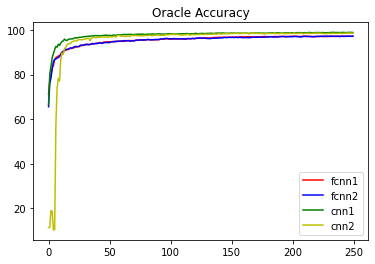

In [13]:
models = [fcnn1, fcnn2, cnn1, cnn2]
candidates = [x['retrain'] for x in models]
plotSteps(0,250, candidates)

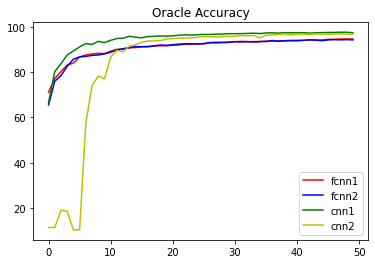

In [14]:
plotSteps(0,50, candidates)

## Strategies for model selection
### 1. Greedy by latest accuracy
test set is constructed of subset of collected data `X[0:t]`   
training set:test set = 9:1

if all training accuracy is same? more complex model

In [7]:
greedy_selection = []
for t in range(len(candidates[0])):
    maxacc = 0
    selected_oracle_acc = 0
    selected_arch = None
    for cand in candidates:
        if cand[t]['test_loss/acc'][0][1][1] > maxacc:
            maxacc = cand[t]['test_loss/acc'][0][1][1]
            selected_oracle_acc = cand[t]['oracle_loss/acc'][0][1][1]
            selected_arch = cand[t]['architecture']
    greedy_selection.append((selected_arch, selected_oracle_acc))

In [9]:
fcnn1_oracle = [x['oracle_loss/acc'][0][1][1] for x in fcnn1['retrain']]
fcnn2_oracle = [x['oracle_loss/acc'][0][1][1] for x in fcnn2['retrain']]
cnn1_oracle = [x['oracle_loss/acc'][0][1][1] for x in cnn1['retrain']]
cnn2_oracle = [x['oracle_loss/acc'][0][1][1] for x in cnn2['retrain']]

In [10]:
oracle_selection = []
for t in range(len(candidates[0])):
    acc_max = 0
    best_m = None
    for cand in candidates:
        if acc_max <= cand[t]['oracle_loss/acc'][0][1][1]:
            acc_max = cand[t]['oracle_loss/acc'][0][1][1]
            best_m = cand[t]['architecture']
    oracle_selection.append((best_m, acc_max))
            

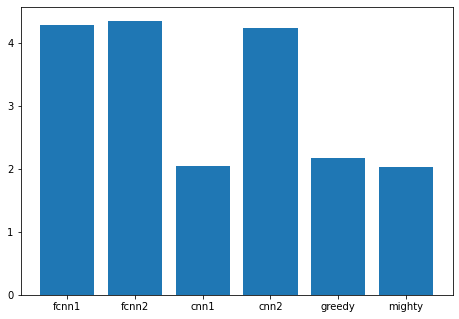

[4.286521739130435, 4.357290969899658, 2.053678929765885, 4.237056856187292, 2.181036789297659, 2.0374916387959856]


In [11]:
regrets = []
regrets.append(regret(fcnn1_oracle))
regrets.append(regret(fcnn2_oracle))
regrets.append(regret(cnn1_oracle))
regrets.append(regret(cnn2_oracle))
regrets.append(regret([x[1] for x in greedy_selection]))
regrets.append(regret([x[1] for x in oracle_selection]))

models = ['fcnn1', 'fcnn2', 'cnn1', 'cnn2', 'greedy', 'mighty']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models, regrets)
plt.show()
print(regrets)

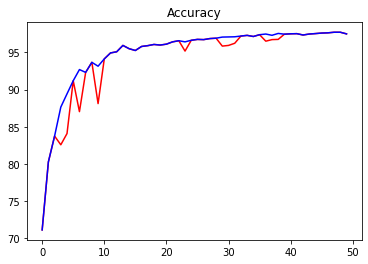

In [20]:
plotAcc(0, 50, [greedy_selection, oracle_selection])

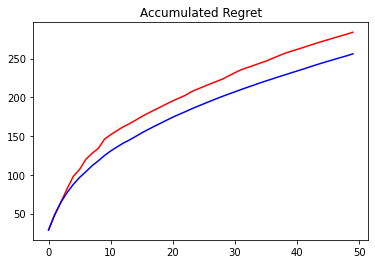

In [26]:
plotAccumulatedRegret(0,50,[greedy_selection, oracle_selection])